In [26]:
# This Notebook contains the relevant cells from PaperPlotandCrossCheck_Edited.ipynb

In [27]:
%load_ext autoreload
%autoreload 2
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
%matplotlib inline
import math
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.linalg
from itertools import product
import gmpy2
#import gmpy

import qiskit
from qiskit import Aer, QuantumCircuit, QuantumRegister, execute


from lattice_qft.Scalar_Field_Theory.classical import *

from lattice_qft.Scalar_Field_Theory import lattice_sft


simulator = Aer.get_backend('unitary_simulator')
simulator_state = Aer.get_backend('statevector_simulator')

In [29]:
# inverse toPhiList test
nL= 3
nQ= 2
dx= 1
lattice1= Lattice(nL, nQ, dx, 1)

for n in range(2**(lattice1.nQ * lattice1.nL)):
    philist= toPhiList(n, lattice1)
    i= toPos(philist, lattice1)
    #print(philist)
    if n != i:
        print(n)
        print(philist)
        print(i)
        print('\n')
print('Done.')

Done.


# Create ground states using the classical methods

Fidelity: Target vs. KW Sheared: 0.9588219786737908
Fidelity: Target vs. KW Not-Sheared: 0.958609197794581
Fidelity: KW Sheared vs. KW Not-Sheared: 0.9841513748683878


/Users/clementcharles/miniconda3/envs/python39_qiskit/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


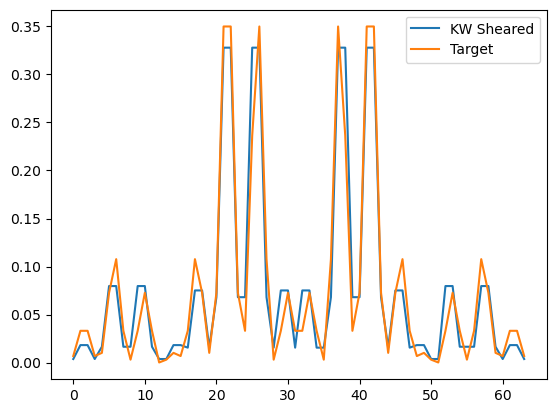

In [30]:
nL= 3
nQ= 2
lattice2= Lattice(nL, nQ, dx, 1)


# KW method, including shearing
groundKW= createKWground(lattice2)

# Generic state prep, exponential algorithm
groundTarget= createEigenstate([0]*nL, lattice2)

# KW method, but omitting shearing
groundNS= createKWstate([0]*nL, lattice2)


plt.plot(groundKW[:], label='KW Sheared')
plt.plot(groundTarget[:], label='Target')

plt.legend()
print('Fidelity: Target vs. KW Sheared: ' + str(qiskit.quantum_info.state_fidelity(groundKW, groundTarget)))
print('Fidelity: Target vs. KW Not-Sheared: ' + str(qiskit.quantum_info.state_fidelity(groundTarget, groundNS)))
print('Fidelity: KW Sheared vs. KW Not-Sheared: ' + str(qiskit.quantum_info.state_fidelity(groundKW, groundNS)))

# Create ground states using circuits from lattice.py

In [31]:
# Compute wavefunctions using circuits in shear.py and lattice.py

#Define some numbers used in the example
dim = 1
dx = 1
nL= 3
#g = .2
trotter_steps_per_dt = 1
evolve_time, trotter_steps = 1, 1


# Fidelity Dics:
sheared_to_default_fidelity= {}
unsheared_to_default_fidelity= {}
sheared_to_unsheared_fidelity= {}

for nQ in range(2,3): # nQ >= 5 are too large to simulate

    print('Creating lattices...\n')
    r= max(int(nQ - 1 + np.ceil(np.log2(nL-1))), nQ)
    num_ancilla= 2*r + 1

    # Lattice object
    lat= lattice_sft.sft_lattice(dim, nL, dx, nQ, num_ancilla)
    
    print('Gij Matrix:')
    print(lat.Gij_matrix())
    print('\n Decomposition:')
    print(lat.KitaevWebbDMDecomposition())
    
    # Set phi_max
    omegalist = lat.omega_list()
    av_omega = np.sum(omegalist) / nL
    phi_max = math.sqrt(math.pi/2 * (2**nQ - 1)**2 / 2**nQ) / math.sqrt(av_omega * dx) # new
    print('\n phi_max: ' + str(phi_max) + '\n')

    
    print('Preparing ground states...')
    # Default (exponential) state prep
    qc_Targ = QuantumCircuit(lat.get_q_register()) # QuantumCircuit
    gs_Targ = lat.ground_state(qc_Targ, lat.get_q_register(), full_correlation=True, shear= False) # ground_state object
    #gs_Targ.build(qc_Targ, lat.get_q_register()) # construct circuit

    # KW state prep, including shearing
    qc_S = QuantumCircuit(lat.get_a_register(), lat.get_q_register())
    gs_S = lat.ground_state(qc_S, lat.get_q_register(), q_ancillas=lat.get_a_register(), full_correlation=False, shear= True)
    #gs_S.build(qc_S, lat.get_q_register(), lat.get_a_register())

    # Only prepare uncorreclated 1D Gaussians
    qc_NS = QuantumCircuit(lat.get_q_register())
    gs_NS = lat.ground_state(qc_NS, lat.get_q_register(), full_correlation=False, shear= False)
    #gs_NS.build(qc_NS, lat.get_q_register())


    print('Simulating and getting statevectors...')
    sv_Targ= execute(qc_Targ, simulator_state).result().get_statevector()
    sv_S= execute(qc_S, simulator_state).result().get_statevector()
    sv_NS= execute(qc_NS, simulator_state).result().get_statevector()
    
    # Ignore ancillas
    sv_Targ_working= sv_Targ.data[np.where(sv_Targ.data > 1e-30)]
    sv_S_working= sv_S.data[np.where(sv_S.data > 1e-30)]
    sv_NS_working= sv_NS.data[np.where(sv_NS.data > 1e-30)]
    print(np.shape(sv_S_working))
    print('Computing fidelities...')
    sheared_to_default_fidelity[nQ]= qiskit.quantum_info.state_fidelity(sv_Targ_working, sv_S_working)
    unsheared_to_default_fidelity[nQ]= qiskit.quantum_info.state_fidelity(sv_Targ_working, sv_NS_working)
    sheared_to_unsheared_fidelity[nQ]= qiskit.quantum_info.state_fidelity(sv_S_working, sv_NS_working)
    
    print('nQ= %d done.\n' %(nQ))
    
print('Fidelities: key= nQ\n')
print('Target vs. KW Sheared: ' + str(sheared_to_default_fidelity))
print('Target vs. KW Not-Sheared: ' + str(unsheared_to_default_fidelity))
print('KW Sheared vs. KW Not-Sheared: ' + str(sheared_to_unsheared_fidelity))
######

#print('Fidelity: Target vs. KW Sheared: ' + str(qiskit.quantum_info.state_fidelity(groundKW, groundTarget)))
#print('Fidelity: Target vs. KW Not-Sheared: ' + str(qiskit.quantum_info.state_fidelity(groundTarget, groundNS)))
#print('Fidelity: KW Sheared vs. KW Not-Sheared: ' + str(qiskit.quantum_info.state_fidelity(groundKW, groundNS)))

Creating lattices...

Gij Matrix:
[[ 1.33333333 -0.33333333  0.33333333]
 [-0.33333333  1.33333333 -0.33333333]
 [ 0.33333333 -0.33333333  1.33333333]]

 Decomposition:
(array([[1.33333333, 0.        , 0.        ],
       [0.        , 1.25      , 0.        ],
       [0.        , 0.        , 1.2       ]]), array([[ 1.  ,  0.25, -0.2 ],
       [ 0.  ,  1.  ,  0.2 ],
       [ 0.  ,  0.  ,  1.  ]]))

 phi_max: 1.6281028227561023

Preparing ground states...
Simulating and getting statevectors...
(64,)
Computing fidelities...
nQ= 2 done.

Fidelities: key= nQ

Target vs. KW Sheared: {2: 0.8267694356305356}
Target vs. KW Not-Sheared: {2: 0.8267694356305333}
KW Sheared vs. KW Not-Sheared: {2: 0.9999999999995528}


# Check if statevectors computed using circuits agree with the classically-computed expectations

Fidelity -- KW Sheared (Circuit) vs. KW Sheared (Classical): 0.8598142252481992
Sum of squared diffs between statevectors: 0.1454766377872732


Fidelity -- Target (Circuit) vs. Target (Classical): 1.0000000000000000
Sum of squared diffs between statevectors: 0.0000000000000000


Fidelity -- KW Not-Sheared (Circuit) vs. KW Not-Sheared (Classical): 0.8598142252481992
Sum of squared diffs between statevectors: 0.1454766377872731




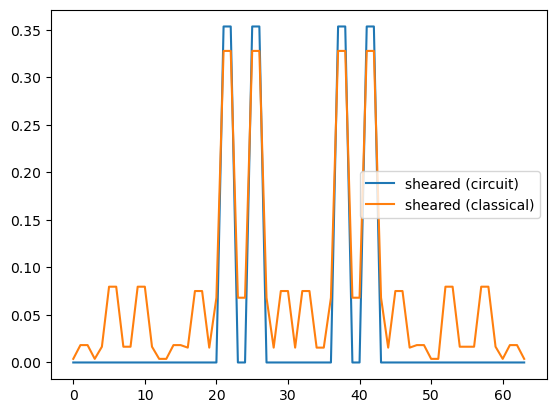

In [32]:
print('Fidelity -- KW Sheared (Circuit) vs. KW Sheared (Classical): %.16f' 
       %(qiskit.quantum_info.state_fidelity(sv_S_working, groundKW)))
print('Sum of squared diffs between statevectors: %.16f'
       %(np.sum(abs(sv_S_working - groundKW)**2)))
print('\n')

print('Fidelity -- Target (Circuit) vs. Target (Classical): %.16f'
       %(qiskit.quantum_info.state_fidelity(sv_Targ_working, groundTarget)))
print('Sum of squared diffs between statevectors: %.16f'
       %(np.sum(abs(sv_Targ_working - groundTarget)**2)))
print('\n')

print('Fidelity -- KW Not-Sheared (Circuit) vs. KW Not-Sheared (Classical): %.16f'
       %(qiskit.quantum_info.state_fidelity(sv_NS_working, groundNS)))
print('Sum of squared diffs between statevectors: %.16f'
       %(np.sum(abs(sv_NS_working - groundNS)**2)))
print('\n')

# Plot some arbitrary section of the wavefunction
rMax= 280
rMin= 0
plt.plot(sv_S_working[rMin:rMax], label='sheared (circuit)')
plt.plot(groundKW[rMin:rMax], label='sheared (classical)')
plt.legend()